## Statistical Inference Gapminder

In [39]:
import os
import pandas  as pd
import seaborn as sns
from pathlib   import Path
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from statsmodels.formula.api import ols

In [17]:
# set root directory
path_root = Path("C:/Users/giann/data-science-core")
os.chdir(path_root)
print(f'- Root directory = {os.getcwd()}')

- Root directory = C:\Users\giann\data-science-core


In [18]:
# import dataset
path_dataset = path_root / 'dataset/gm_2008_region.csv'
data  = pd.read_csv(path_dataset)
data.head()

,population,fertility,HIV,CO2,BMI_male,GDP,BMI_female,life,child_mortality,Region
0,34811059.0,2.73,0.1,3.328945,24.59620,12314.0,129.9049,75.3,29.5,Middle East & North Africa
1,19842251.0,6.43,2.0,1.474353,22.25083,7103.0,130.1247,58.3,192.0,Sub-Saharan Africa
2,40381860.0,2.24,0.5,4.785170,27.50170,14646.0,118.8915,75.5,15.4,America
3,2975029.0,1.40,0.1,1.804106,25.35542,7383.0,132.8108,72.5,20.0,Europe & Central Asia
4,21370348.0,1.96,0.1,18.016313,27.56373,41312.0,117.3755,81.5,5.2,East Asia & Pacific


### Empirical cumulative distribution function (ECDF)
Another way to show how the data are distributed

In [19]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)
    # x-data for the ECDF: x
    x = np.sort(data)
    # y-data for the ECDF: y
    y = np.arange(1, len(x)+1) / n
    return x, y

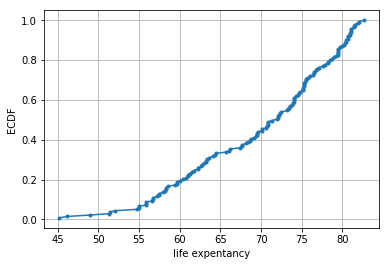

In [20]:
# Compute ECDF for the total life expentancy
x_life, y_life = ecdf(data['life'])
# Generate plot
plt.plot(x_life, y_life, marker = '.', linestyle = '-')
plt.ylabel('ECDF')
plt.xlabel('life expentancy')
plt.grid()
plt.show()

In [21]:
# get quantile
q25, median, q75 = np.percentile(data['life'] , [25, 50, 75])
print(f"25% quantile = {q25} | 50% quantile = {median} | 75% quantile = {q75}")

25% quantile = 62.2 | 50% quantile = 72.0 | 75% quantile = 76.85


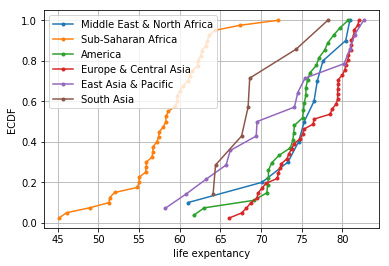

In [22]:
# Compute ECDF per Region
for Region in data['Region'].unique() :
    # Compute ECDF for the total life expentancy
    x_life, y_life = ecdf(data.loc[data['Region'] == Region ,'life'])
    # Generate plot
    plt.plot(x_life, y_life, marker = '.', linestyle = '-', label = Region)

plt.legend(loc = 'upper left')
plt.ylabel('ECDF')
plt.xlabel('life expentancy')
plt.grid()
plt.show() 

A substancial difference in term of life expectancy w.r.t. region.

## Statistical Inference
- draw probabilistic conclusions about what we might expect if we collected the same data over and over again.
- To draw more general conclusions from relatively few data or observations.
- Data are almost never exactly the same when acquired again, and probability allows us to say how much we expect them to vary.
- we use **bootstraping** i.e. a simulated replica of the actual experiment obtained **resampling the data with replament**.

### Check normality of Life Expectancy
Note that the estimated parameter are optimal for the model we choose for our data! 

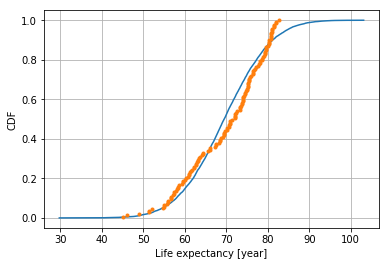

In [24]:
# Compute mean and standard deviation from data: mu, sigma
y_var = 'life'
mu    = np.mean(data[y_var])
sigma = np.std(data[y_var])

# Sample out of a normal distribution with this mu and sigma: samples
samples = np.random.normal(mu, sigma, size = 10000)

# Get the CDF of the samples and of the data
x_theor, y_theor = ecdf(samples)
x, y = ecdf(data[y_var])

# Plot the CDFs and show the plot
_ = plt.plot(x_theor, y_theor)
_ = plt.plot(x, y, marker='.', linestyle='none')
_ = plt.xlabel('Life expectancy [year]')
_ = plt.ylabel('CDF')
plt.grid()
plt.show()

### Bootstrap ECDF
Bootstrap samples give an idea of how the distribution of `life expectancy` is spread.

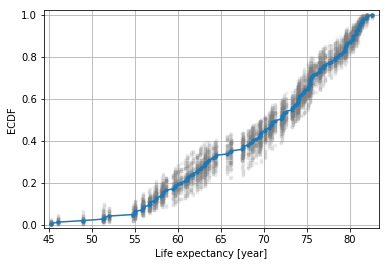

In [25]:
for i in range(50):
    # Generate bootstrap sample: bs_sample
    bs_sample = np.random.choice(data[y_var], size=len(data[y_var]))

    # Compute and plot ECDF from bootstrap sample
    x, y = ecdf(bs_sample)
    _ = plt.plot(x, y, marker='.', linestyle='none',
                 color='gray', alpha=0.1)

# Compute and plot ECDF from original data
x, y = ecdf(data[y_var])
_ = plt.plot(x, y, marker='.')

# Make margins and label axes
plt.margins(0.02)
_ = plt.xlabel('Life expectancy [year]')
_ = plt.ylabel('ECDF')
plt.grid()
plt.show()

### Standard Error of the Mean (SEM) 
The standard error of the mean is the standard deviation of the sampling distribution of the mean. The formula $\sigma_{\mu} = \frac{\sigma}{\sqrt(N)}$ where $\sigma$ is the standard deviation of the original distribution and $N$ is the sample size (the number of scores each mean is based upon). This formula does not assume a normal distribution. However, many of the uses of the formula do assume a normal distribution. 

In [26]:
## define function which generate many bootstrap replicates
def bootstrap_replicate_1d(data, func):
    """Generate bootstrap replicate of 1D data."""
    bs_sample = np.random.choice(data, len(data))
    return func(bs_sample)

def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""
    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)
    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)
    return bs_replicates

# Take 10,000 bootstrap replicates of the mean: bs_replicates
bs_replicates = draw_bs_reps(data[y_var], np.mean, size = 10000)

In [27]:
# Compute and print  SEM
sem = np.std(data[y_var]) / np.sqrt(len(data[y_var]))
print(f"o standard error of the mean = {round(sem, 2)}")

# Compute and print standard deviation of bootstrap replicates
bs_std = np.std(bs_replicates)
print(f"o standard deviation of bootstrap replicates = {round(bs_std, 2)}")

o standard error of the mean = 0.77
o standard deviation of bootstrap replicates = 0.78


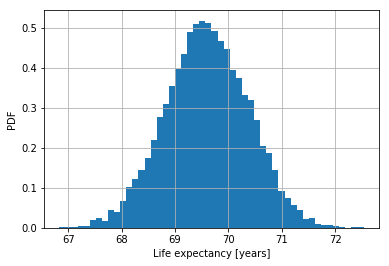

In [28]:
# Make a histogram of the results
_ = plt.hist(bs_replicates, bins = 50, density = True)
_ = plt.xlabel('Life expectancy [years]')
_ = plt.ylabel('PDF')
plt.grid()
plt.show()

Notice that the **SEM** got from the known expression and the bootstrap replicates is the same and the distribution of the bootstrap replicates of the mean is Normal.

### Compute 95% confidence interval
A confidence interval gives upper and lower bounds on the range of parameter values you might expect to get if we repeat our measurements. Bootstrap method is that you can take percentiles of your bootstrap replicates to get your confidence interval.

In [29]:
[q25, q95] = np.percentile(bs_replicates, [2.5, 97.5])
print(f"o 95% confidence interval of the mean is = [{round(q25, 2)}, {round(q95, 2)}] years")

o 95% confidence interval of the mean is = [68.08, 71.1] years


### Bootstrap variance

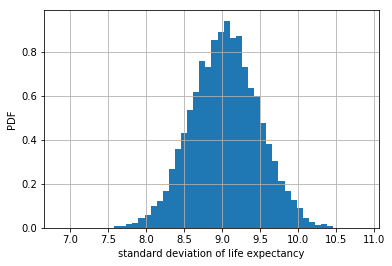

o 95% confidence interval of the std is = [8.18, 9.91] years


In [30]:
# Generate 10,000 bootstrap replicates of the variance: bs_replicates
bs_replicates = draw_bs_reps(data[y_var], np.std, 10000)

# Make a histogram of the results
_ = plt.hist(bs_replicates, density = True, bins = 50)
_ = plt.xlabel('standard deviation of life expectancy')
_ = plt.ylabel('PDF')
plt.grid()
plt.show()
[q25, q95] = np.percentile(bs_replicates, [2.5, 97.5])
print(f"o 95% confidence interval of the std is = [{round(q25, 2)}, {round(q95, 2)}] years")

The mean and variance are not very Normal since both have a fat tail on the right.

## Linear regression analysis

In [31]:
# variable which we want to perfomr analysis
x_var = 'child_mortality'
y_var = 'life'

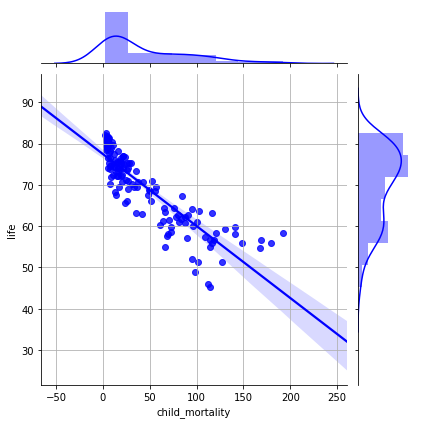

In [32]:
sns.jointplot(x = x_var, y = y_var, data = data, kind = 'reg', color = 'b')
plt.grid()
plt.show()

In [33]:
print(f" o pearson corr = {pearsonr(data[x_var], data[y_var])[0]}")
print(f" o p-value = {pearsonr(data[x_var], data[y_var])[1]}")

 o pearson corr = -0.8741061295399251
 o p-value = 8.452380463280616e-45


The **p-value** roughly indicates the probability of an uncorrelated system producing datasets that have a Pearson correlation at least as extreme as the one computed from these datasets. The p-values are not entirely reliable but are probably reasonable for datasets larger than 500 or so. **p-value** quantifies in term of probability the *chance that our estimate for a certain quantity could have been obtained by random chance*.

In [34]:
# Perform a linear regression using np.polyfit(): a, b
a, b = np.polyfit(x = data[x_var], y = data[y_var], deg = 1)
# Print the results to the screen
print('o slope =', round(a, 2), 'year life expentancy / child mortality')
print('o intercept =', round(b, 2), 'year of life expentancy')

o slope = -0.17 year life expentancy / child mortality
o intercept = 77.47 year of life expentancy


Results shows that the categorical feature `Region` might potentially have a predictive power for `life` targer variable

### Residual analysis

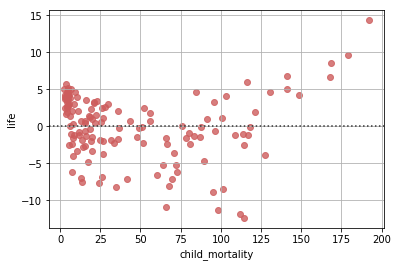

In [35]:
sns.residplot(x = x_var, y = y_var, data = data, color = 'indianred')
plt.grid()
plt.show()

### Pairs bootstrap for linear regression
- Resample data in pairs
- Compute slope and intercept from resampled data
- Each slope and intercept is a bootstrap replicate
- Compute confidence intervals from percentiles of bootstrap replicates

In [36]:
def draw_bs_pairs_linreg(x, y, size=1):
    """Perform pairs bootstrap for linear regression."""
    # Set up array of indices to sample from: inds
    inds = np.arange(len(x))
    # Initialize replicates: bs_slope_reps, bs_intercept_reps
    bs_slope_reps = np.empty(size)
    bs_intercept_reps = np.empty(size)
    # Generate replicates
    for i in range(size):
        bs_inds = np.random.choice(inds, size=len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_slope_reps[i], bs_intercept_reps[i] = np.polyfit(bs_x,bs_y,deg =1)
    return bs_slope_reps, bs_intercept_reps

Estimate of the slope from the `life`/`child_mortality` data. Also report the 95% confidence interval of the slope.

In [37]:
# Generate replicates of slope and intercept using pairs bootstrap
bs_slope_reps, bs_intercept_reps = draw_bs_pairs_linreg(data[x_var], data[y_var], size =1000)

o 95% confidence interval of the slope is = [-0.2, -0.15] life_expectancy / child_mortality


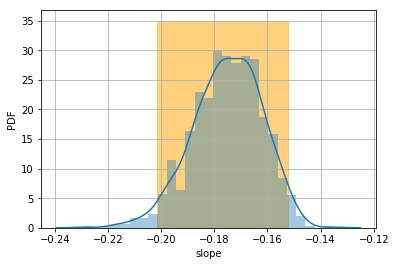

In [38]:
# Compute and print 95% CI for slope
[q25, q97] = np.percentile(bs_slope_reps, [2.5, 97.5])
print(f"o 95% confidence interval of the slope is = [{round(q25, 2)}, {round(q97, 2)}] life_expectancy / child_mortality")

# Plot the histogram
_ = sns.distplot(bs_slope_reps)
_ = plt.xlabel('slope')
_ = plt.ylabel('PDF')
_ = plt.fill_between([q25, q97], [35, 35], color = 'orange', alpha = 0.5)
plt.grid()
plt.show()

### Plot 99%, 95% and 90% confidence interval of `intercept` and `slope`

In [72]:
model_fit = ols(formula="life ~ GDP + BMI_female + child_mortality", data = data).fit()

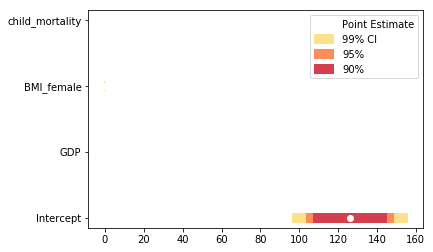

In [73]:
# Add interval percent widths
alphas = [     0.01,  0.05,   0.1] 
widths = [ '99% CI', '95%', '90%']
colors = ['#fee08b','#fc8d59','#d53e4f']

for alpha, color, width in zip(alphas, colors, widths):
    # Grab confidence interval
    conf_ints = model_fit.conf_int(alpha)
    
    # Pass current interval color and legend label to plot
    plt.hlines(y = conf_ints.index, xmin = conf_ints[0], xmax = conf_ints[1],
               colors = color, label = width, linewidth = 10) 

# Draw point estimates
plt.plot(model_fit.params, model_fit.params.index, 'wo', label = 'Point Estimate')

plt.legend()
plt.show() 

### Plotting bootstrap regressions
Visualization of the variability of the linear regression is to plot the line you would get from each bootstrap replicate of the **slope** and **intercept**.

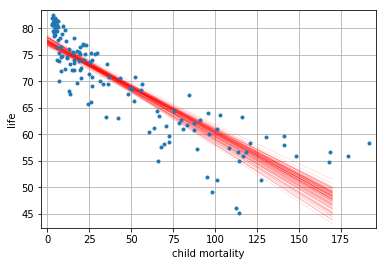

In [78]:
# Generate array of x-values for bootstrap lines: x
x = np.array([0,170])

# Plot the bootstrap lines
for i in range(100):
    _ = plt.plot(x, bs_slope_reps[i]*x + bs_intercept_reps[i], linewidth = 0.5, alpha = 0.2, color='red')

# Plot the data
_ = plt.plot(data[x_var], data[y_var], marker = '.', linestyle = 'none')

# Label axes, set the margins, and show the plot
_ = plt.xlabel('child mortality')
_ = plt.ylabel('life')
plt.grid()
plt.margins(0.02)
plt.show()

### Test Hypothesis
Test that two variables have identical probability distributions. Test hypothesis is based on **permutation samples** are constructed by concatenating two the arrays (`n1`, `n2`) together, scrambling the contents of the concatenated array, and then taking the first `n1` entries as the permutation sample of the first array and the last `n2` entries as the permutation sample of the second array.

In [80]:
def permutation_sample(data1, data2):
    """Generate a permutation sample from two data sets."""
    # Concatenate the data sets: data
    data = np.concatenate((data1,data2))
    # Permute the concatenated array: permuted_data
    permuted_data = np.random.permutation(data)
    # Split the permuted array into two: perm_sample_1, perm_sample_2
    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2 = permuted_data[len(data1):]
    return perm_sample_1, perm_sample_2

Let us consider the life expectancy for different `Region`. We expect these might be differently distributed, so we will take permutation samples to see how their **ECDFs** would look if they were identically distributed.

In [84]:
life_Africa = data.loc[data['Region'] == 'Sub-Saharan Africa'   , 'life']
life_Europe = data.loc[data['Region'] == 'Europe & Central Asia', 'life']

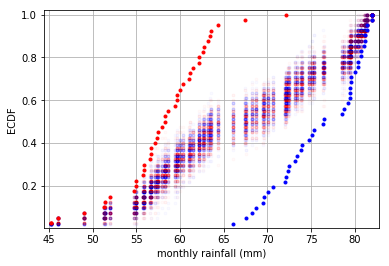

In [88]:
for i in range(200):
    # Generate permutation samples
    perm_sample_1, perm_sample_2 = permutation_sample(life_Africa, life_Europe)
    # Compute ECDFs
    x_1, y_1 = ecdf(perm_sample_1)
    x_2, y_2 = ecdf(perm_sample_2)
    # Plot ECDFs of permutation sample
    _ = plt.plot(x_1, y_1, marker='.', linestyle = 'none', color = 'red' , alpha = 0.02)
    _ = plt.plot(x_2, y_2, marker='.', linestyle = 'none', color = 'blue', alpha = 0.02)

# Create and plot ECDFs from original data
x_1, y_1 = ecdf(life_Africa)
x_2, y_2 = ecdf(life_Europe)
_ = plt.plot(x_1, y_1, marker='.', linestyle='none', color='red' , label = 'life exp Africa')
_ = plt.plot(x_2, y_2, marker='.', linestyle='none', color='blue', label = 'life exp Europe')

# Label axes, set margin, and show plot
plt.margins(0.02)
_ = plt.xlabel('monthly rainfall (mm)')
_ = plt.ylabel('ECDF')
plt.grid()
plt.show()

**null hypothesis** : Test that two variables have identical probability distributions. 
Notice that the permutation samples ECDFs overlap and give a purple haze. None of the ECDFs from the permutation samples overlap with the observed data, suggesting that the hypothesis is not commensurate with the data. life expectancy for different region are **not** identically distributed.